In [1]:
import keras
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from PIL import Image
import matplotlib.pyplot as plt

In [8]:
model = tf.keras.applications.InceptionResNetV2(include_top=True, weights='imagenet')
model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.inception_resnet_v2.decode_predictions

In [10]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (299, 299))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [11]:
image_path = "./plane.jpeg"
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


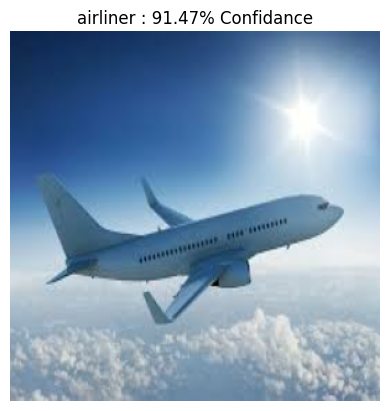

In [12]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')
plt.show()
plt.close()

In [13]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

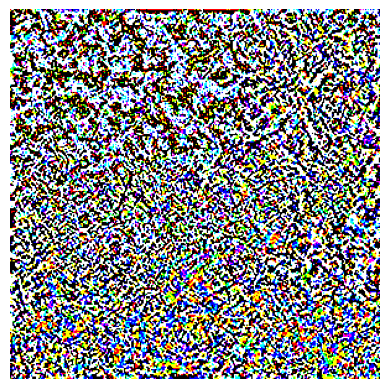

In [14]:
# Get the input label of the image.
labrador_retriever_index = 41
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]
plt.axis('off');

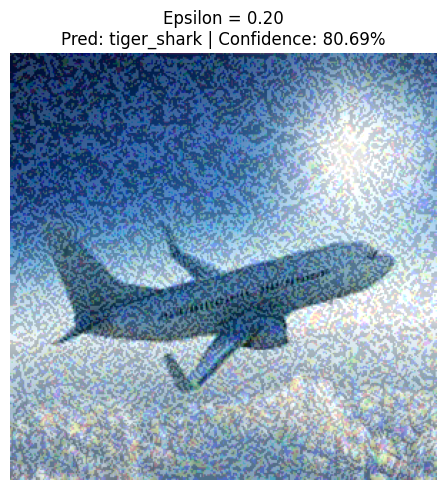

In [23]:
epsilon = .2
description = f"Epsilon = {epsilon:.2f}"

# Generate adversarial image
adv_x = image + epsilon * perturbations
adv_x = tf.clip_by_value(adv_x, -1, 1)

# Predict label
pred = model(adv_x)
label = get_imagenet_label(pred)

# Plot
plt.figure(figsize=(5, 5))
plt.imshow(adv_x[0] * 0.5 + 0.5)  # Convert from [-1, 1] to [0, 1] for display
plt.title(f"{description}\nPred: {label[1]} | Confidence: {label[2]*100:.2f}%")
plt.axis('off')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


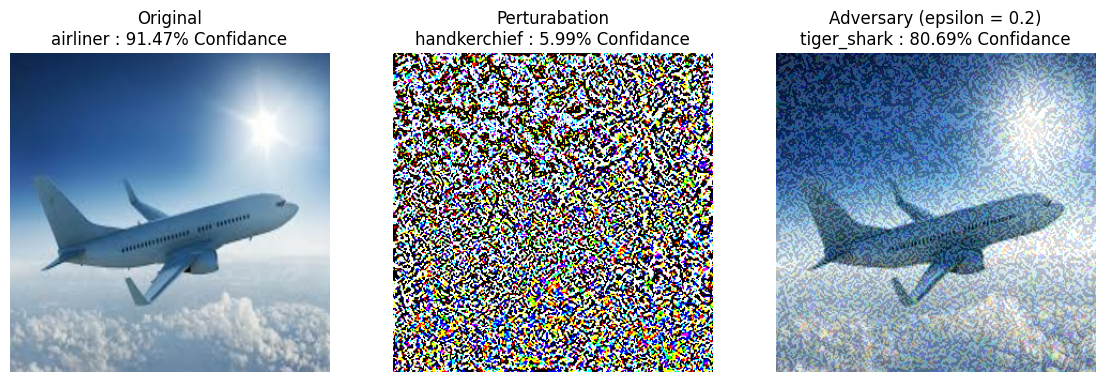

In [25]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.imshow(image[0] * 0.5 + 0.5) # To change [-1, 1] to [0,1]
_, image_class, class_confidance = get_imagenet_label(image_probs)
plt.title('Original\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(perturbations[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(perturbations))
plt.title('Perturabation\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(adv_x[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(adv_x))
plt.title('Adversary (epsilon = 0.2)\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.show()
plt.close()

In [26]:
adv_x.shape, adv_x.dtype, image.shape, image.dtype

(TensorShape([1, 299, 299, 3]),
 tf.float32,
 TensorShape([1, 299, 299, 3]),
 tf.float32)

In [27]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

/Users/mdhasnainali/Researcher/my-venv/ml_tf/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


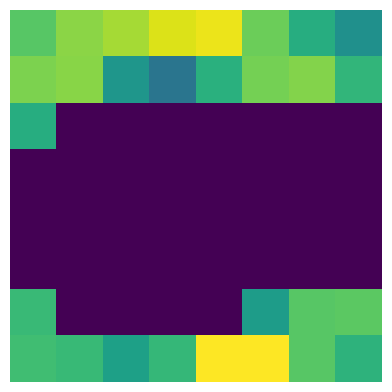

In [30]:
heatmap = make_gradcam_heatmap(img_array=adv_x, model=model, last_conv_layer_name='conv_7b', pred_index=48)
# Display heatmap
plt.matshow(heatmap)
plt.axis('off')
plt.show()

In [51]:
def save_and_display_gradcam(img_tensor, heatmap, alpha=0.4):
    img = img_tensor[0].numpy()                 # shape: (224, 224, 3), range [-1, 1]
    img = (img + 1.0) / 2.0                      # scale to [0, 1]
    img = np.uint8(255 * img)                   # scale to [0, 255]

    # Rescale heatmap to [0, 255]
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]     # shape: (256, 3)
    jet_heatmap = jet_colors[heatmap]           # shape: (H, W, 3), still float32 in [0, 1]

    # Resize heatmap directly using PIL (more accurate resizing)
    heatmap_img = Image.fromarray(np.uint8(jet_heatmap * 255))
    heatmap_img = heatmap_img.resize((img.shape[1], img.shape[0]), resample=Image.BILINEAR)
    jet_heatmap = np.array(heatmap_img)         # shape: (H, W, 3), dtype: uint8

    # Superimpose
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
    superimposed_img = np.uint8(superimposed_img)

    return superimposed_img
    # plt.matshow(superimposed_img)
    # plt.axis('off')
    # plt.show()

### Original

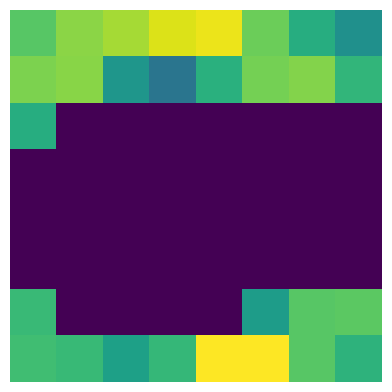

In [33]:
heatmap_original = make_gradcam_heatmap(img_array=image, model=model, last_conv_layer_name='conv_7b', pred_index=41)
# Display heatmap
plt.matshow(heatmap)
plt.axis('off')
plt.show()

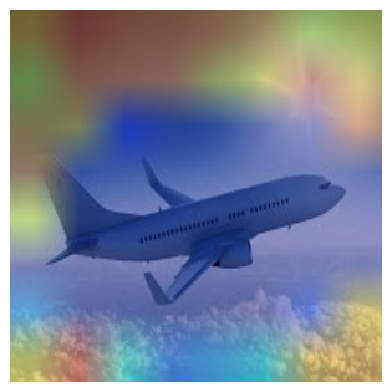

In [36]:
save_and_display_gradcam(image, heatmap=heatmap_original)

In [37]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [38]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [39]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

In [40]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [41]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

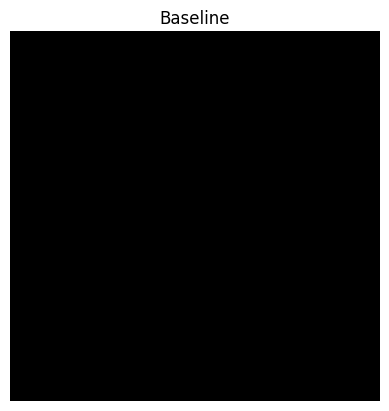

In [44]:
baseline = tf.zeros(shape=(299,299,3))
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [45]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=adv_x[0],
                                       target_class_idx=48,
                                       m_steps=240)

In [46]:
print(ig_attributions.shape)

(299, 299, 3)


In [47]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image* 0.5 + 0.5)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask * 0.5 + 0.5, cmap=cmap)
  axs[1, 1].imshow(image * 0.5 + 0.5, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

In [48]:
def generate_attribution_mask(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
  return attribution_mask

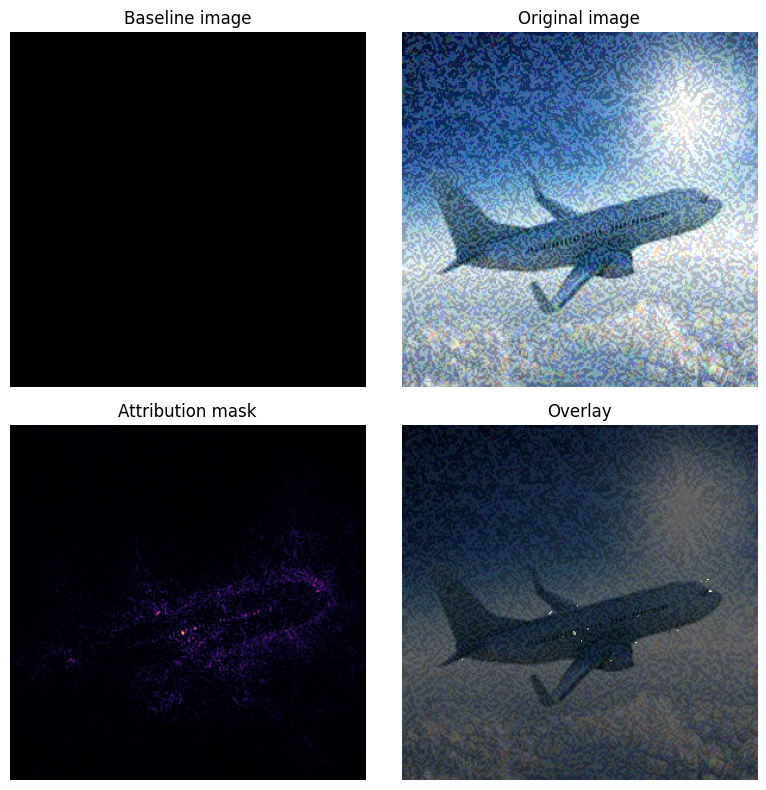

In [49]:
_ = plot_img_attributions(image=adv_x[0],
                          baseline=baseline,
                          target_class_idx=48,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


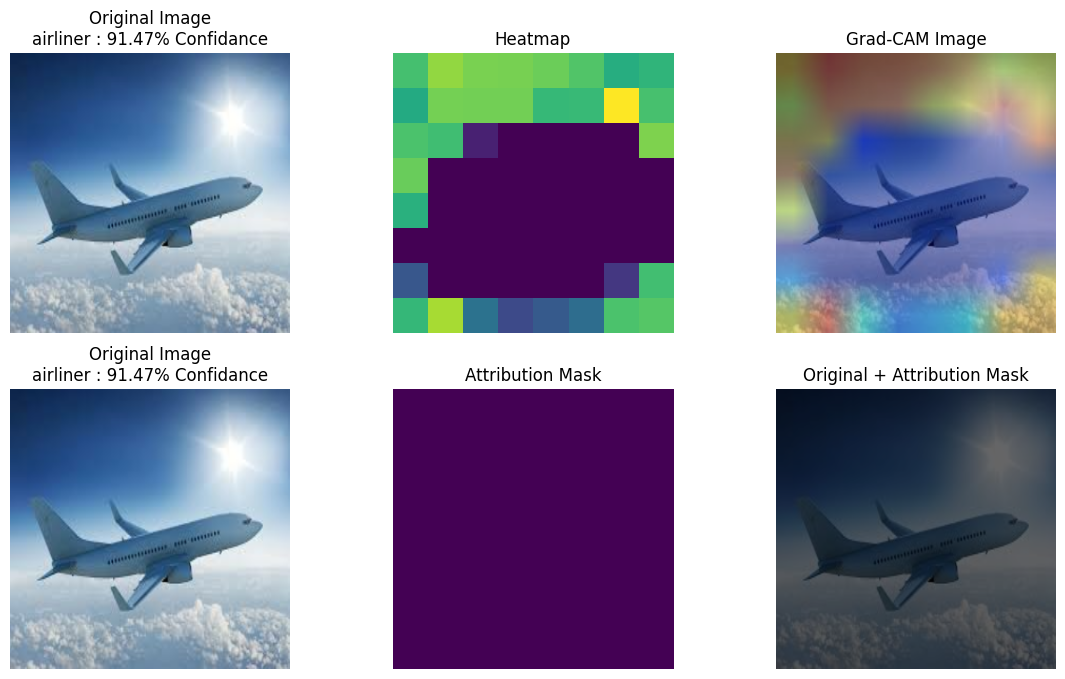

In [52]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(image))
plt.title('Original Image\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 2)
heatmap_original = make_gradcam_heatmap(img_array=image, model=model, last_conv_layer_name='conv_7b', pred_index=41)
plt.imshow(heatmap_original * 0.5 + 0.5)
plt.title("Heatmap")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(save_and_display_gradcam(image, heatmap_original))
plt.title("Grad-CAM Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(image))
plt.title('Original Image\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 5)
attribution_mask = generate_attribution_mask(image=image[0], baseline=baseline, target_class_idx=41, m_steps=240,)
plt.imshow(attribution_mask * 0.5 + 0.5)
plt.title('Attribution Mask')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(attribution_mask * 0.5 + 0.5, cmap=plt.cm.inferno)
plt.imshow(image[0] * 0.5 + 0.5, alpha=0.4, cmap=plt.cm.inferno)
plt.title("Original + Attribution Mask")
plt.axis('off')

plt.show()
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


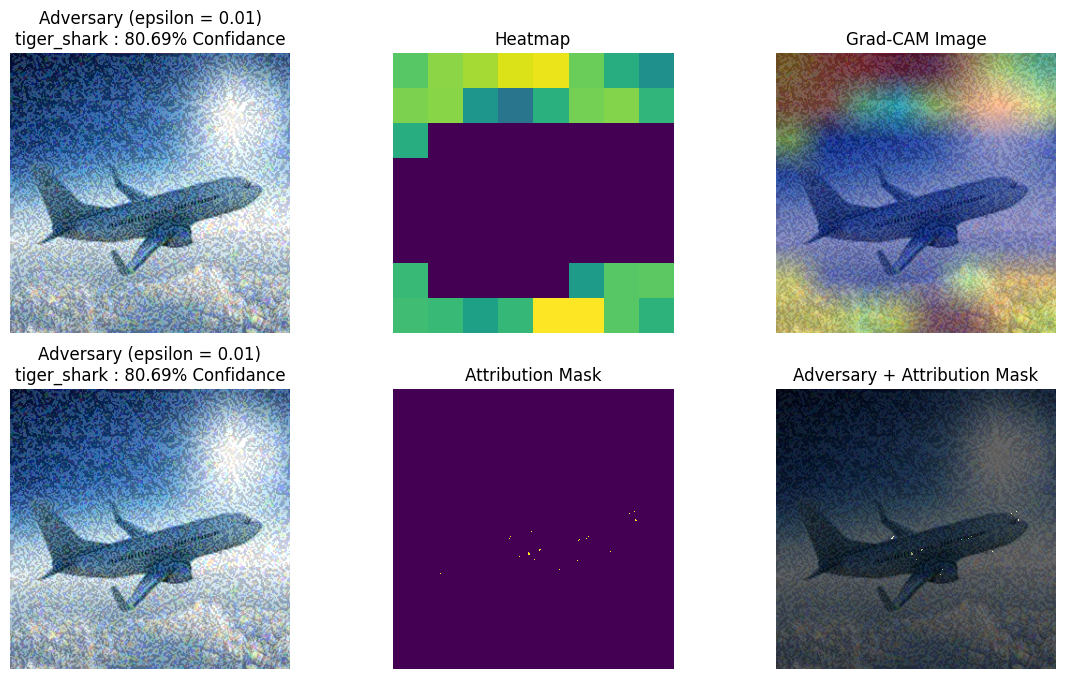

In [53]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(adv_x[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(adv_x))
plt.title('Adversary (epsilon = 0.01)\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 2)
heatmap = make_gradcam_heatmap(img_array=adv_x, model=model, last_conv_layer_name='conv_7b', pred_index=48)
plt.imshow(heatmap * 0.5 + 0.5)
plt.title("Heatmap")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(save_and_display_gradcam(adv_x, heatmap))
plt.title("Grad-CAM Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(adv_x[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(adv_x))
plt.title('Adversary (epsilon = 0.01)\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 5)
attribution_mask = generate_attribution_mask(image=adv_x[0], baseline=baseline, target_class_idx=48, m_steps=240,)
plt.imshow(attribution_mask * 0.5 + 0.5)
plt.title('Attribution Mask')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(attribution_mask * 0.5 + 0.5, cmap=plt.cm.inferno)
plt.imshow(adv_x[0] * 0.5 + 0.5, alpha=0.4, cmap=plt.cm.inferno)
plt.title("Adversary + Attribution Mask")
plt.axis('off')

plt.show()
plt.close()

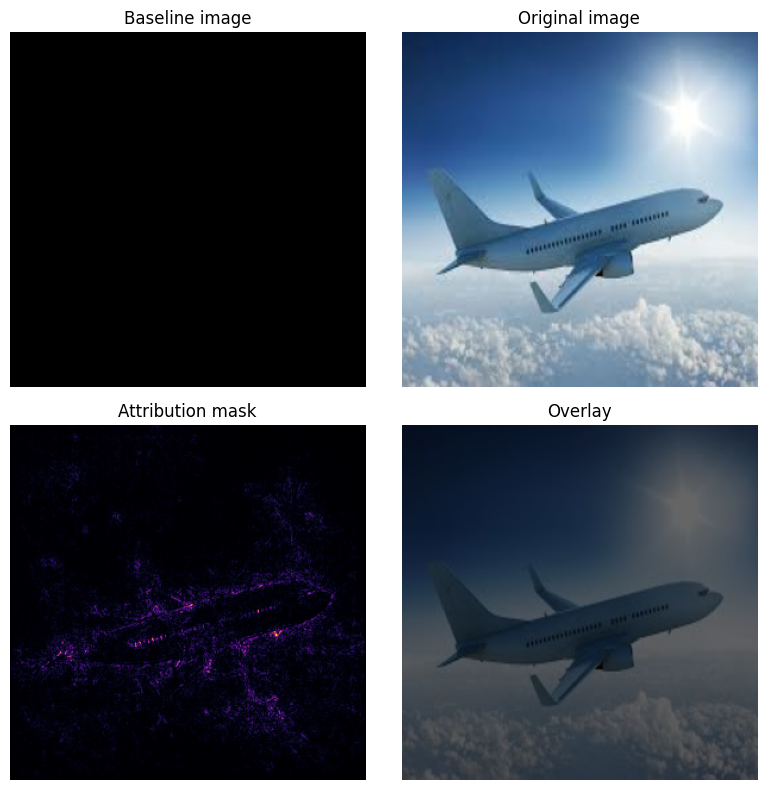

In [54]:
_ = plot_img_attributions(image=image[0],
                          baseline=baseline,
                          target_class_idx=41,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)